In [2]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import shapiro,normaltest

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from collections import defaultdict 
import itertools

import datetime
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta

import pymssql

# Credentials
server = '172.31.10.243' 
database = 'dump_tables' 

user = 'vivek.kapoor'
password = 'Y5WfWgFK}93n>8;5'
driver = '{ODBC Driver 17 for SQL Server}'
database = 'dump_tables' 

conn = pymssql.connect(host='172.31.10.243', 
                       user=user, 
                       password=password,
                       database=database, 
                       as_dict=True)

cursor = conn.cursor()

/Users/vivekkapoor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working


In [3]:
# Meta for IPL dates

ipl_start_date = '2020-09-19'
ipl_end_date = '2020-11-10'
ipl_double_headers = set(['2020-10-03', '2020-10-04', '2020-10-10', '2020-10-11', '2020-10-17', 
                          '2020-10-18', '2020-10-24', '2020-10-25', '2020-10-31', '2020-11-01'])

# Minimum daily wager condition
wager = 10000

In [4]:
# Create IPL date range from start to end and dump it in a list

ipl_sdate = date(int(ipl_start_date.split('-')[0]),
                 int(ipl_start_date.split('-')[1]),
                 int(ipl_start_date.split('-')[2]))

ipl_edate = date(int(ipl_end_date.split('-')[0]),
                 int(ipl_end_date.split('-')[1]),
                 int(ipl_end_date.split('-')[2]))

ipl_dates = list(pd.date_range(ipl_sdate,ipl_edate,freq='d'))

In [5]:
# Dictionary that maps dates to playing hours.
# Single header match days start at 1900 hours and end at 0000 hour
# Double header match days start at 1500 hours and end at 0000 hour

date_time_dict = defaultdict()
for dt in ipl_dates:
    if str(dt.date()) in ipl_double_headers:
        date_time_dict[str(dt.date())] = 15
    else:
        date_time_dict[str(dt.date())] = 19

In [6]:
# This keeps track of number of days into the IPL and puts these dates in a set for logical checks later

date_parameters = ipl_start_date.split('-')
today = date.today()

sdate = date(int(date_parameters[0]), int(date_parameters[1]), int(date_parameters[2]))   # start date
edate = today - timedelta(days = 1) # which is yesterday

date_set = list(pd.date_range(sdate,edate,freq='d'))
date_set = set([str(dt.date()) for dt in date_set])

In [7]:
## Query to pull active days and wagering data using relevant conditions from SQL Server

wagering_query = """
  select userid
--        ,date
--        ,type
--        ,entryfee
        ,case when userid%2 = 1 then 'test' else 'control' end as test_control
        ,sum(CashgameCount*entryfee) as wager
        ,sum(CashgameCount) as gamecount
        ,sum(coalesce(winnings,0)+coalesce(amountlost,0)) as winnings
        ,sum(gamewon) as gamewon
        ,sum(gamelost) as gamelost
        ,sum((coalesce(winnings,0)+coalesce(amountlost,0))*rake_percent) as rake
        ,sum(gametime) as gametime
    from Dump_tables..r2CashAndFree a with (nolock)
   where hour >= {hr}
     and date = '{dt}'
     and gameType = 'CashGame'
group by userid
--        ,date
--        ,type
--        ,entryfee
        ,case when userid%2 = 1 then 'test' else 'control' end
"""

In [8]:
%%time

user_metrics = None

# Execute datapull and logic
day_count = 0
for dt, hr in date_time_dict.items():
    
    if dt in date_set:
        if user_metrics is None:
            user_metrics = pd.read_sql_query(wagering_query.format(dt=dt,hr=hr),conn)
        else:
            user_metrics = pd.concat([user_metrics,pd.read_sql_query(wagering_query.format(dt=dt,hr=hr),conn)],axis=0)
        
        print('Data for {dt} pulled......'.format(dt=dt),'\tObs running total:',len(user_metrics))
            
print('\n')
print('Done!')

Data for 2020-09-19 pulled...... 	Obs running total: 65391
Data for 2020-09-20 pulled...... 	Obs running total: 130869
Data for 2020-09-21 pulled...... 	Obs running total: 198874
Data for 2020-09-22 pulled...... 	Obs running total: 265043
Data for 2020-09-23 pulled...... 	Obs running total: 330144
Data for 2020-09-24 pulled...... 	Obs running total: 396190
Data for 2020-09-25 pulled...... 	Obs running total: 461377
Data for 2020-09-26 pulled...... 	Obs running total: 527209
Data for 2020-09-27 pulled...... 	Obs running total: 581045
Data for 2020-09-28 pulled...... 	Obs running total: 634281
Data for 2020-09-29 pulled...... 	Obs running total: 690369
Data for 2020-09-30 pulled...... 	Obs running total: 745661
Data for 2020-10-01 pulled...... 	Obs running total: 800773
Data for 2020-10-02 pulled...... 	Obs running total: 856482
Data for 2020-10-03 pulled...... 	Obs running total: 926473
Data for 2020-10-04 pulled...... 	Obs running total: 995129
Data for 2020-10-05 pulled...... 	Obs run

In [9]:
user_metrics.head()

,userid,test_control,wager,gamecount,winnings,gamewon,gamelost,rake,gametime
0,6004,control,116,6,166.59,3.0,3.0,24.9885,2446
1,6046,control,10000,5,22599.40,3.0,2.0,2259.9400,4114
2,18424,control,28700,60,18619.28,18.0,42.0,2187.5870,6028
3,34956,control,35,2,50.50,1.0,1.0,7.5750,2440
4,41542,control,250,1,250.00,NaN,1.0,37.5000,1353


## Check cleanliness of test

In [10]:
from bokeh.plotting import figure
from bokeh.io import show, output_notebook

In [11]:
class BokehHistogram():

    def __init__(self, colors=["SteelBlue", "Tan"], height=600, width=600):
        self.colors = colors
        self.height = height
        self.width = width

    def hist_hover(self, dataframe, column, bins=30, log_scale=False, show_plot=True):
        hist, edges = np.histogram(dataframe[column], bins = bins)
        hist_df = pd.DataFrame({column: hist,
                                 "left": edges[:-1],
                                 "right": edges[1:]})
        hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                               right in zip(hist_df["left"], hist_df["right"])]

        if log_scale == True:
            hist_df["log"] = np.log(hist_df[column])
            src = ColumnDataSource(hist_df)
            plot = figure(plot_height = self.height, plot_width = self.width,
                  title = "Histogram of {}".format(column.capitalize()),
                  x_axis_label = column.capitalize(),
                  y_axis_label = "Log Count")    
            plot.quad(bottom = 0, top = "log",left = "left", 
                right = "right", source = src, fill_color = self.colors[0], 
                line_color = "black", fill_alpha = 0.7,
                hover_fill_alpha = 1.0, hover_fill_color = self.colors[1])
        else:
            src = ColumnDataSource(hist_df)
            plot = figure(plot_height = self.height, plot_width = self.width,
                  title = "Histogram of {}".format(column.capitalize()),
                  x_axis_label = column.capitalize(),
                  y_axis_label = "Count")    
            plot.quad(bottom = 0, top = column,left = "left", 
                right = "right", source = src, fill_color = self.colors[0], 
                line_color = "black", fill_alpha = 0.7,
                hover_fill_alpha = 1.0, hover_fill_color = self.colors[1])

        hover = HoverTool(tooltips = [('Interval', '@interval'),
                                  ('Count', str("@" + column))])
        plot.add_tools(hover)

        if show_plot == True:
            show(plot)
        else:
            return plot

    def histotabs(self, dataframe, features, log_scale=False, show_plot=False):
        hists = []
        for f in features:
            h = self.hist_hover(dataframe, f, log_scale=log_scale, show_plot=show_plot)
            p = Panel(child=h, title=f.capitalize())
            hists.append(p)
        t = Tabs(tabs=hists)
        show(t)

    def filtered_histotabs(self, dataframe, feature, filter_feature, log_scale=False, show_plot=False):
        hists = []
        for col in dataframe[filter_feature].unique():
            sub_df = dataframe[dataframe[filter_feature] == col]
            histo = self.hist_hover(sub_df, feature, log_scale=log_scale, show_plot=show_plot)
            p = Panel(child = histo, title=col)
            hists.append(p)
        t = Tabs(tabs=hists)
        show(t)

In [39]:
h = BokehHistogram()

In [ ]:
h.hist_hover(df.fillna(0, axis=1), 'nevents', log_scale=True)
h.histotabs(df.fillna(0, axis=1), ['nevents', 'ndays_act', 'nchapters'], log_scale=True)
h.filtered_histotabs(df.fillna(0, axis=1), 'nevents', 'final_cc_cname_DI', log_scale=True)

## Visually observe boxcox to guage if normal distribution holds

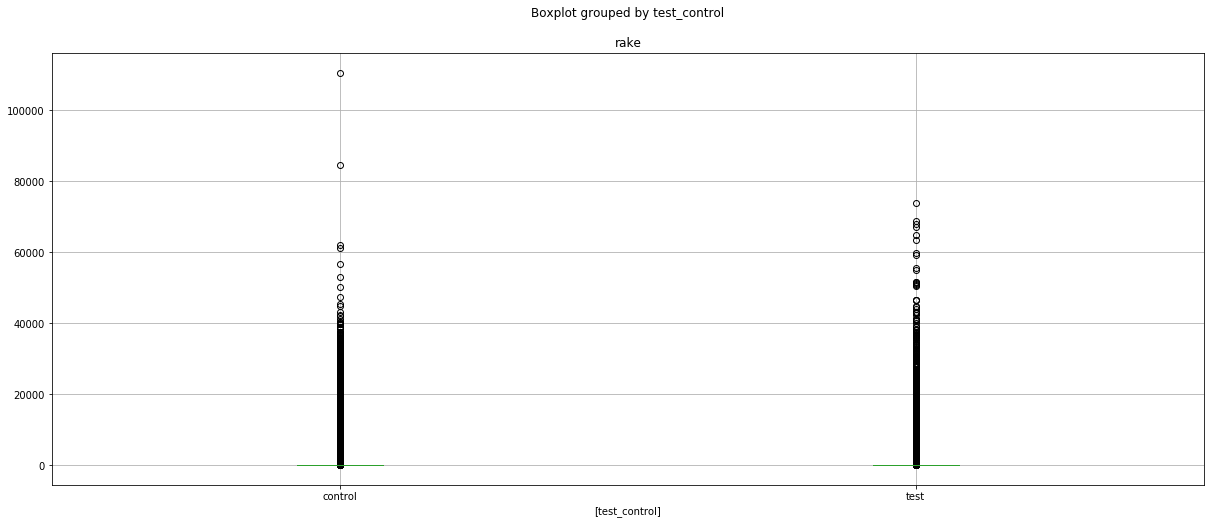

In [13]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences 
# between different treatments
user_metrics.boxplot(column=['rake'], by=['test_control'],figsize=(20,8))
plt.show()

#### If not normal, in most cases taking the log transformation brings to closer to a normal distribution. Especially in case of continuous monetory metrics - Rake, Costs, Winnings, etc

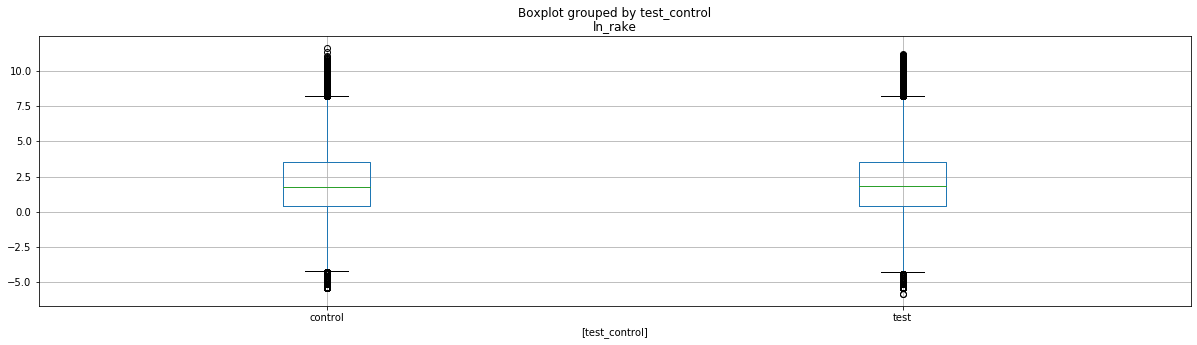

In [14]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can easily detect the differences 
# between different treatments
user_metrics['ln_rake'] = np.log(user_metrics['rake'])
user_metrics.boxplot(column=['ln_rake'], by=['test_control'],figsize=(20,5))
plt.show()

In [15]:
print('Test rake count',user_metrics[user_metrics['test_control']=='test'].rake.count())
print('Test rake mean',user_metrics[user_metrics['test_control']=='test'].rake.mean())
print('Test rake max',user_metrics[user_metrics['test_control']=='test'].rake.max())
print('\n')
print('Control rake count',user_metrics[user_metrics['test_control']=='control'].rake.count())
print('Control rake mean',user_metrics[user_metrics['test_control']=='control'].rake.mean())
print('Control rake max',user_metrics[user_metrics['test_control']=='control'].rake.max())

Test rake count 609891
Test rake mean 161.388632880961
Test rake max 73860.0


Control rake count 608331
Control rake mean 159.08512004764384
Control rake max 110622.29999999999


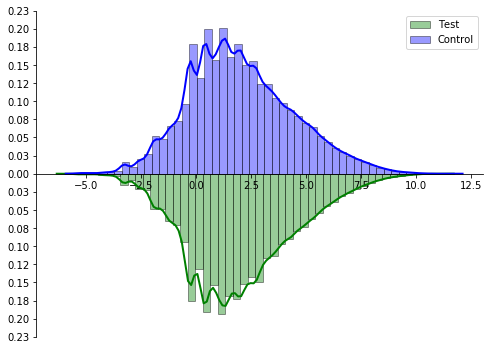

In [22]:
test = np.array(user_metrics[user_metrics['test_control']=='test'].ln_rake.values)
control = np.array(user_metrics[user_metrics['test_control']=='control'].ln_rake.values)

fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(test, hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, 
             bins=50, label = 'Test',
             color='green')
for p in ax.patches:  # turn the histogram upside down
    p.set_height(-p.get_height())
for l in ax.lines:  # turn the kde curve upside down
    l.set_ydata(-l.get_ydata())

sns.distplot(control, hist=True, kde=True, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2}, 
             bins=50,label = 'Control',
             color='blue')
# ax.set_xticks(np.arange(0, 121, 20))
# ax.set_yticks(np.arange(0.0, 0.07, 0.01))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

pos_ticks = np.array([t for t in ax.get_yticks() if t > 0])
ticks = np.concatenate([-pos_ticks[::-1], [0], pos_ticks])
ax.set_yticks(ticks)
ax.set_yticklabels([f'{abs(t):.2f}' for t in ticks])
ax.spines['bottom'].set_position('zero')

plt.legend()
plt.show()

## To double check, run normality test

In [18]:
def normality_test(metric,variant):
    data = user_metrics[user_metrics['test_control']==variant]
    data = np.array(data[metric].values)
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.1
    if p > alpha:
        print(variant,':','Sample looks Gaussian (fail to reject H0)','\n')
    else:
        print(variant,':','Sample does not look Gaussian (reject H0)','\n')

In [19]:
normality_test('ln_rake','test')
normality_test('ln_rake','control')

Statistics=13512.117, p=0.000
test : Sample does not look Gaussian (reject H0) 

Statistics=13305.224, p=0.000
control : Sample does not look Gaussian (reject H0) 



## Finally run t-test and conclude

In [20]:
def run_ttest(metric,variant1,variant2):
    sample1 = user_metrics[user_metrics['test_control']==variant1]
    sample1 = np.array(sample1[metric].values)

    sample2 = user_metrics[user_metrics['test_control']==variant2]
    sample2 = np.array(sample2[metric].values)

    t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)
    
    if p_val > 0.1:
        significance = 'Sample means are same'
    else:
        significance = 'Sample means are different'

    print('Variant1:',variant1,'Variant2:',variant2,significance,'p_value = ',p_val,'\n')

In [21]:
run_ttest('ln_rake','test','control')

Variant1: test Variant2: control Sample means are same p_value =  0.503042668876267 

